In [1]:
import os

import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import Model
from flow_layers import parametric_real_nvp # For vector parameteric maps

# Plotting
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
#Build the model which does basic map of inputs to coefficients
class normalizing_flow(Model):
    def __init__(self,data,params):
        super(normalizing_flow, self).__init__()

        self.dim = data.shape[1]
        self.data = data
        self.params = params

        # Define real_nvp flow layers
        self.l0 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l1 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l2 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        self.l3 = parametric_real_nvp(scale_dim=1,num_dims=2,shuffle=True)
        

        # Training optimizer
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)

        # Moving statistics
        self.moving_mean = None
        self.moving_std = None

    @tf.function
    def call(self, x, params): # x to z (forward)

        h1, ldj1 = self.l0(x,params) # Individual layer calls
        h2, ldj2 = self.l1(h1,params)
        h3, ldj3 = self.l2(h2,params)
        hfinal, ldj4 = self.l3(h3,params)

        logdet = ldj1+ldj2+ldj3+ldj4

        log_prior = -0.5*tf.math.reduce_sum(tf.math.square(hfinal))

        neg_ll = - log_prior - logdet

        return hfinal, neg_ll

    @tf.function
    def call_backward(self,z,params): # z to x

        h = self.l3.invert(z,params) # Individual layer calls
        h = self.l2.invert(h,params) # Individual layer calls
        h = self.l1.invert(h,params) # Individual layer calls
        h = self.l0.invert(h,params) # Individual layer calls

        return h

    # perform gradient descent
    @tf.function
    def network_learn(self,x,params):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            _, neg_ll = self.call(x,params)
            g = tape.gradient(neg_ll, self.trainable_variables)

        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    @tf.function
    def extract_gradient(self,input_grad,params):
        params = tf.convert_to_tensor(params)
        z = tf.convert_to_tensor(input_grad)
        
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(z)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(params)
                with tf.GradientTape(persistent=True) as tape3:
                    tape3.watch(params)
                    x = self.call_backward(z,params)
    
                g1 = tape3.batch_jacobian(x, params)
            g2 = tape2.batch_jacobian(g1, params)
        v = tape1.batch_jacobian(g1, z)
        
        return g1, g2, v

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 10
        best_valid_loss = np.inf # Some large number 

        self.num_batches = 10
        self.ntrain = int(0.7*self.data.shape[0])
        self.nvalid = self.data.shape[0] - int(0.7*self.data.shape[0])

        self.train_data = self.data[:self.ntrain]
        self.train_params = self.params[:self.ntrain]

        self.valid_data = self.data[self.ntrain:]
        self.valid_params = self.params[self.ntrain:]

        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.ntrain/self.num_batches)
        
        for i in range(2000):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                batch_data = self.train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                batch_params = self.train_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(batch_data,batch_params)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                batch_data = self.valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                batch_params = self.valid_params[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                valid_loss = valid_loss + np.sum(self.call(batch_data,batch_params)[1].numpy())

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation negative log likelihood from:',best_valid_loss,' to:', valid_loss)
                
                best_valid_loss = valid_loss

                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation negative log likelihood (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                self.train_op._hyper['learning_rate'] = 0.5*self.train_op._hyper['learning_rate']
                print('Reduced learning rate to',self.train_op._hyper['learning_rate'])
                stop_iter = 0
                
                if self.train_op._hyper['learning_rate'] < 1e-6:
                    break

In [3]:
def visualize_samples(samples,params,time=0,eps=0.01):
    # At a specific time
    plot_samples = []
    for i in range(params.shape[0]):
        if params[i,0] < time+eps and params[i,0] > time-eps:
            plot_samples.append(samples[i])

    plot_samples = np.asarray(plot_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Density at parameter:'+str(time))
    plt.show()

In [4]:
train_mode = True
num_samples = 1000
noise_list = np.arange(0.0,1.0,step=0.01)

train_list = []
param_list = []
for i in range(len(noise_list)):
    train_list.append(make_moons(n_samples=num_samples,noise=noise_list[i])[0])
    param_list.append(np.ones(shape=(num_samples,1))*noise_list[i])

train_data = train_list[0]
param_data = param_list[0]
for i in range(1,len(train_list)):
    train_data = np.concatenate((train_data,train_list[i]),axis=0)
    param_data = np.concatenate((param_data,param_list[i]),axis=0)

In [5]:
idx = np.arange(start=0,stop=train_data.shape[0])
np.random.shuffle(idx)

train_data = train_data[idx,:]
param_data = param_data[idx,:]

In [6]:
# Normalizing flow training
flow_model = normalizing_flow(train_data,param_data)
z = np.random.normal(size=train_data.shape)
pre_samples = flow_model.call_backward(z,param_data) # Forward is x to z, Backward is z to x
pre_samples = pre_samples.numpy()

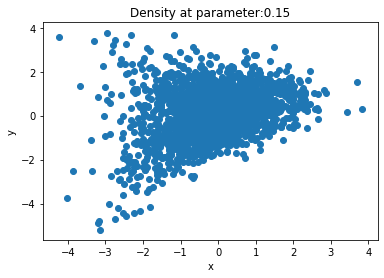

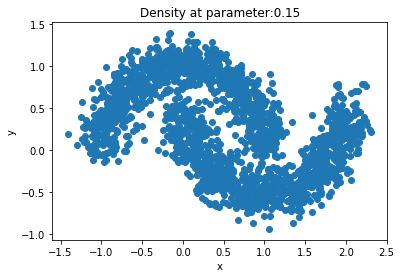

In [7]:
visualize_samples(pre_samples,param_data,time=0.15)
visualize_samples(train_data,param_data,time=0.15)

In [8]:
if train_mode:
    flow_model.train_model()
    flow_model.load_weights('./checkpoints/my_checkpoint')
else:
    flow_model.load_weights('./checkpoints/my_checkpoint')

Training iteration: 0
Improved validation negative log likelihood from: inf  to: 23076.394547599884
Training iteration: 1
Improved validation negative log likelihood from: 23076.394547599884  to: 21206.101552306227
Training iteration: 2
Improved validation negative log likelihood from: 21206.101552306227  to: 19762.737649512273
Training iteration: 3
Improved validation negative log likelihood from: 19762.737649512273  to: 18847.41374440156
Training iteration: 4
Improved validation negative log likelihood from: 18847.41374440156  to: 18281.024908497893
Training iteration: 5
Improved validation negative log likelihood from: 18281.024908497893  to: 17826.693286201913
Training iteration: 6
Improved validation negative log likelihood from: 17826.693286201913  to: 17451.48531403313
Training iteration: 7
Improved validation negative log likelihood from: 17451.48531403313  to: 17172.677900212926
Training iteration: 8
Improved validation negative log likelihood from: 17172.677900212926  to: 169

Improved validation negative log likelihood from: 12817.789493723127  to: 12806.827538081994
Training iteration: 73
Improved validation negative log likelihood from: 12806.827538081994  to: 12790.73885979803
Training iteration: 74
Improved validation negative log likelihood from: 12790.73885979803  to: 12748.786155679887
Training iteration: 75
Improved validation negative log likelihood from: 12748.786155679887  to: 12735.404683721057
Training iteration: 76
Improved validation negative log likelihood from: 12735.404683721057  to: 12732.495855676949
Training iteration: 77
Improved validation negative log likelihood from: 12732.495855676949  to: 12700.673084088708
Training iteration: 78
Improved validation negative log likelihood from: 12700.673084088708  to: 12671.209336139218
Training iteration: 79
Improved validation negative log likelihood from: 12671.209336139218  to: 12649.611737513227
Training iteration: 80
Validation negative log likelihood (no improvement): 12662.654935639872
Tr

Validation negative log likelihood (no improvement): 11828.89118922559
Training iteration: 152
Validation negative log likelihood (no improvement): 11967.928026117777
Training iteration: 153
Validation negative log likelihood (no improvement): 11988.891428394196
Training iteration: 154
Validation negative log likelihood (no improvement): 11900.008278083213
Training iteration: 155
Validation negative log likelihood (no improvement): 11982.012203936923
Training iteration: 156
Validation negative log likelihood (no improvement): 11971.803639454876
Reduced learning rate to tf.Tensor(0.0005, shape=(), dtype=float32)
Training iteration: 157
Validation negative log likelihood (no improvement): 11893.913151293622
Training iteration: 158
Validation negative log likelihood (no improvement): 12010.875461613063
Training iteration: 159
Validation negative log likelihood (no improvement): 12109.139258895108
Training iteration: 160
Validation negative log likelihood (no improvement): 11902.0474146192

Validation negative log likelihood (no improvement): 11532.582430636669
Training iteration: 232
Improved validation negative log likelihood from: 11468.458059001494  to: 11426.52777434657
Training iteration: 233
Validation negative log likelihood (no improvement): 11444.274611368663
Training iteration: 234
Validation negative log likelihood (no improvement): 11430.392371125654
Training iteration: 235
Improved validation negative log likelihood from: 11426.52777434657  to: 11420.610944169308
Training iteration: 236
Validation negative log likelihood (no improvement): 11426.976157436662
Training iteration: 237
Validation negative log likelihood (no improvement): 11513.66675904852
Training iteration: 238
Validation negative log likelihood (no improvement): 11658.46471710004
Training iteration: 239
Validation negative log likelihood (no improvement): 11698.138941606612
Training iteration: 240
Validation negative log likelihood (no improvement): 11449.088747997896
Training iteration: 241
Im

Validation negative log likelihood (no improvement): 11866.129061310581
Training iteration: 314
Validation negative log likelihood (no improvement): 11772.865542962192
Training iteration: 315
Validation negative log likelihood (no improvement): 11733.891311213907
Reduced learning rate to tf.Tensor(3.90625e-06, shape=(), dtype=float32)
Training iteration: 316
Validation negative log likelihood (no improvement): 11679.3042843515
Training iteration: 317
Validation negative log likelihood (no improvement): 11635.056381325834
Training iteration: 318
Validation negative log likelihood (no improvement): 11619.227480942845
Training iteration: 319
Validation negative log likelihood (no improvement): 11598.94184973044
Training iteration: 320
Validation negative log likelihood (no improvement): 11583.198942938023
Training iteration: 321
Validation negative log likelihood (no improvement): 11562.308037831532
Training iteration: 322
Validation negative log likelihood (no improvement): 11555.5383544

In [9]:
z = np.random.normal(size=train_data.shape)
post_samples = flow_model.call_backward(z,param_data)
post_samples = post_samples.numpy()

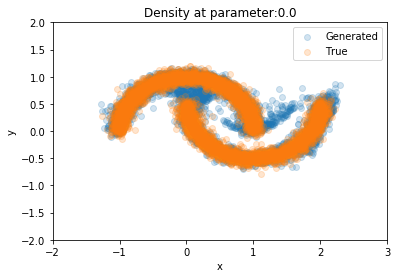

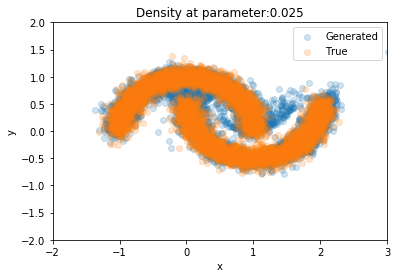

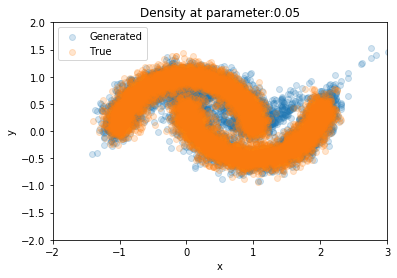

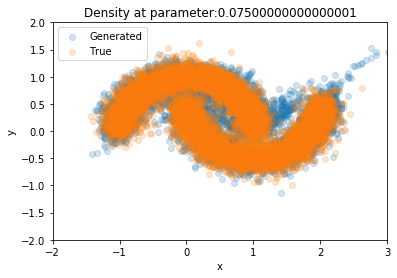

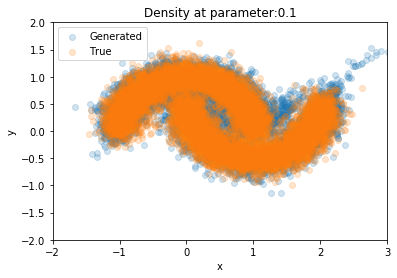

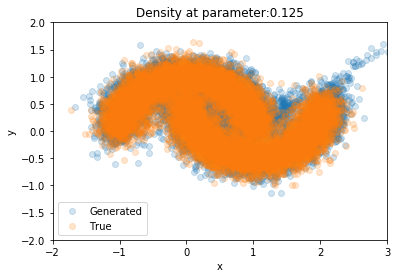

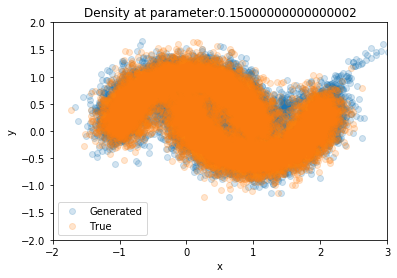

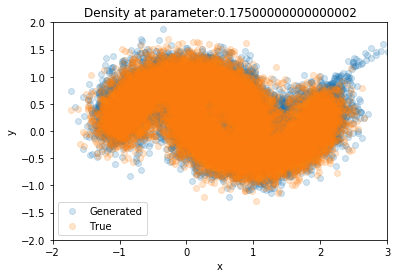

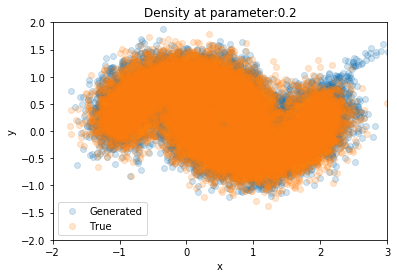

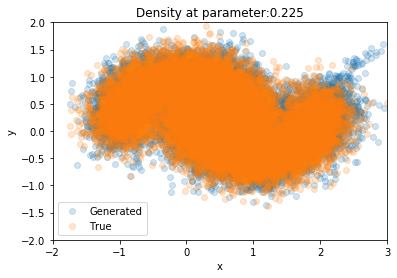

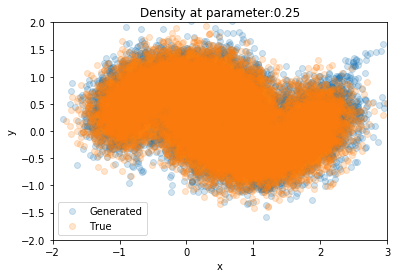

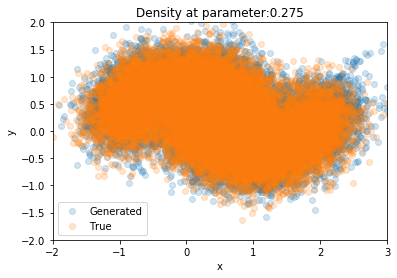

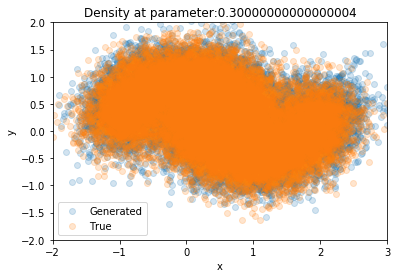

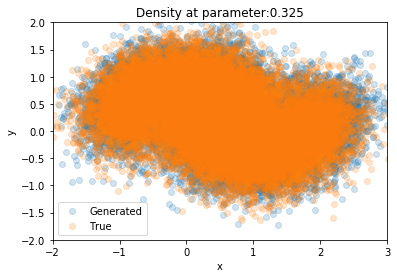

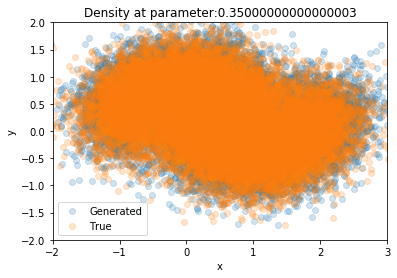

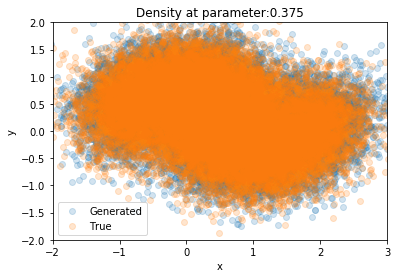

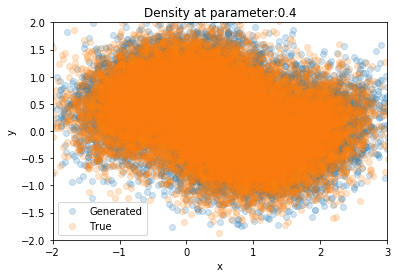

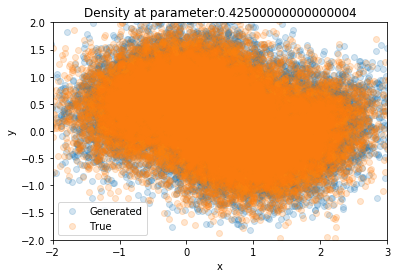

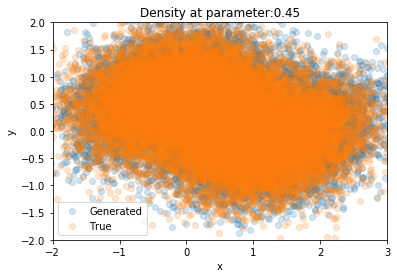

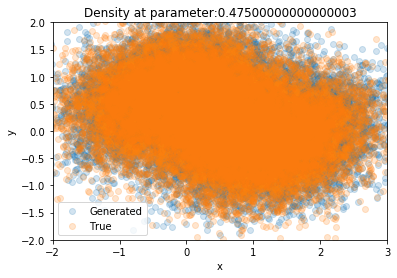

In [13]:
final_time = 0.5
# At a specific parameter
for time in np.arange(0.0,final_time,0.025):
    
    eps = 0.1
    plot_samples = []
    target_samples = []

    for i in range(param_data.shape[0]):
        if param_data[i,0] < time+eps and param_data[i,0] > time-eps:
            plot_samples.append(post_samples[i])
            target_samples.append(train_data[i])

    plot_samples = np.asarray(plot_samples)
    target_samples = np.asarray(target_samples)

    plt.figure()
    plt.scatter(plot_samples[:,0],plot_samples[:,1],label='Generated',alpha=0.2)
    plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2,label='True')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((-2,3))
    plt.ylim((-2,2))
    plt.title('Density at parameter:'+str(time))
    plt.legend()
    plt.show()

In [14]:
zx = np.linspace(-1, 1, 200)
zy = np.linspace(-1, 1, 200)

zxv, zyv = np.meshgrid(zx, zy)
zxvflat = zxv.reshape(-1,1)
zyvflat = zyv.reshape(-1,1)

grid = np.concatenate((zxvflat,zyvflat),axis=-1)
params = np.zeros(shape=(grid.shape[0],1))

### Extracting the gradients etc and plotting

/home/rmlans/miniconda3/envs/tf2_env/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Reshape:0", shape=(None, 40000), dtype=float64), dense_shape=Tensor("gradients/gradients/gradients/transpose_grad/transpose/x/pfor/UnsortedSegmentSum_grad/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


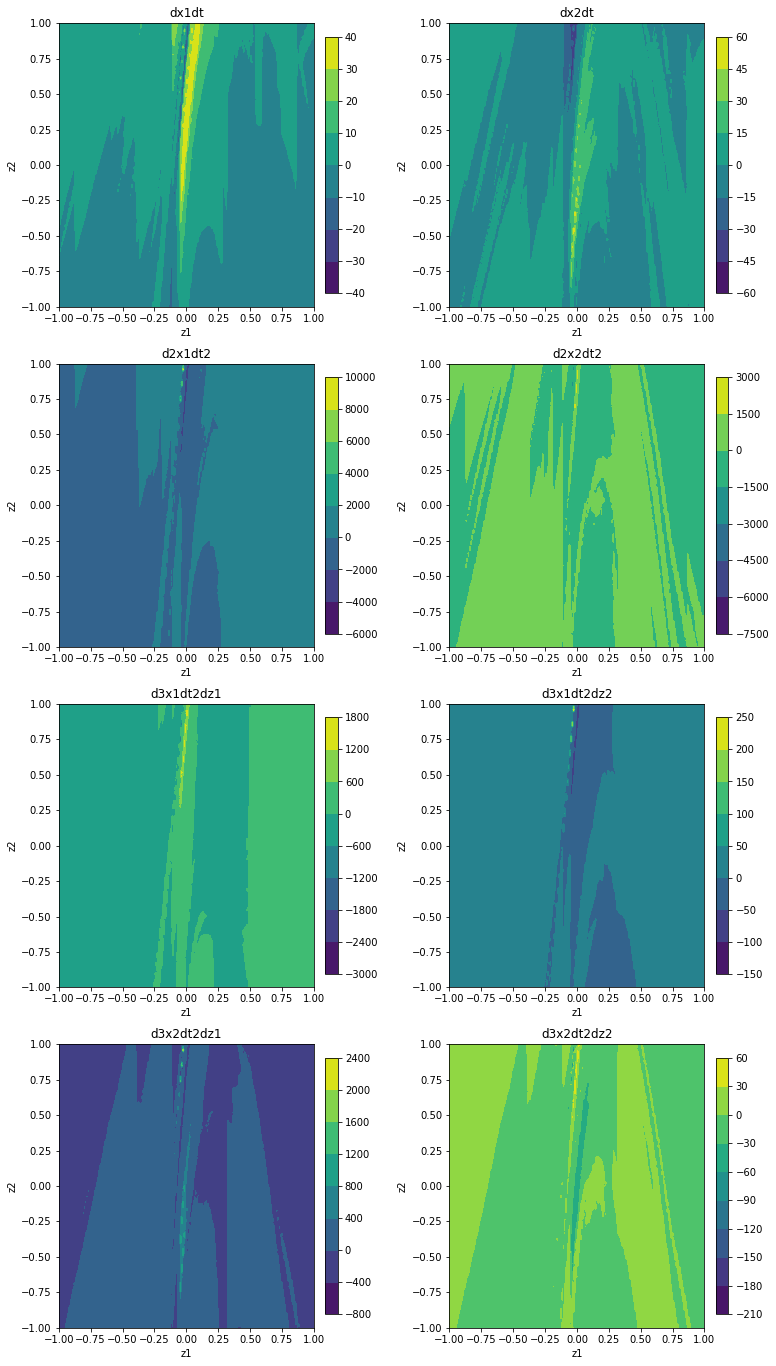

In [15]:
params[:,0] = 0.05 # Time
g1, g2, v = flow_model.extract_gradient(grid,params)

# Gradient of x1, x2 with respect to t (velocity)
dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])

# Second derivative of x1, x2 with respect to t (acceleration)
d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d2x2dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

# Derivative of velocity with respect to z1, z2 (directional derivative of velocity)
d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
ax[0,0].set_title('dx1dt')
cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
ax[0,1].set_title('dx2dt')
cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
ax[1,0].set_title('d2x1dt2')
cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
ax[1,1].set_title('d2x2dt2')

cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
ax[2,0].set_title('d3x1dt2dz1')

cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
ax[2,1].set_title('d3x1dt2dz2')

cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
ax[3,0].set_title('d3x2dt2dz1')

cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
ax[3,1].set_title('d3x2dt2dz2')


for i in range(4):
    for j in range(2):
        ax[i,j].set_xlabel('z1')
        ax[i,j].set_ylabel('z2')

fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
plt.subplots_adjust(wspace = 0.4)
plt.show()

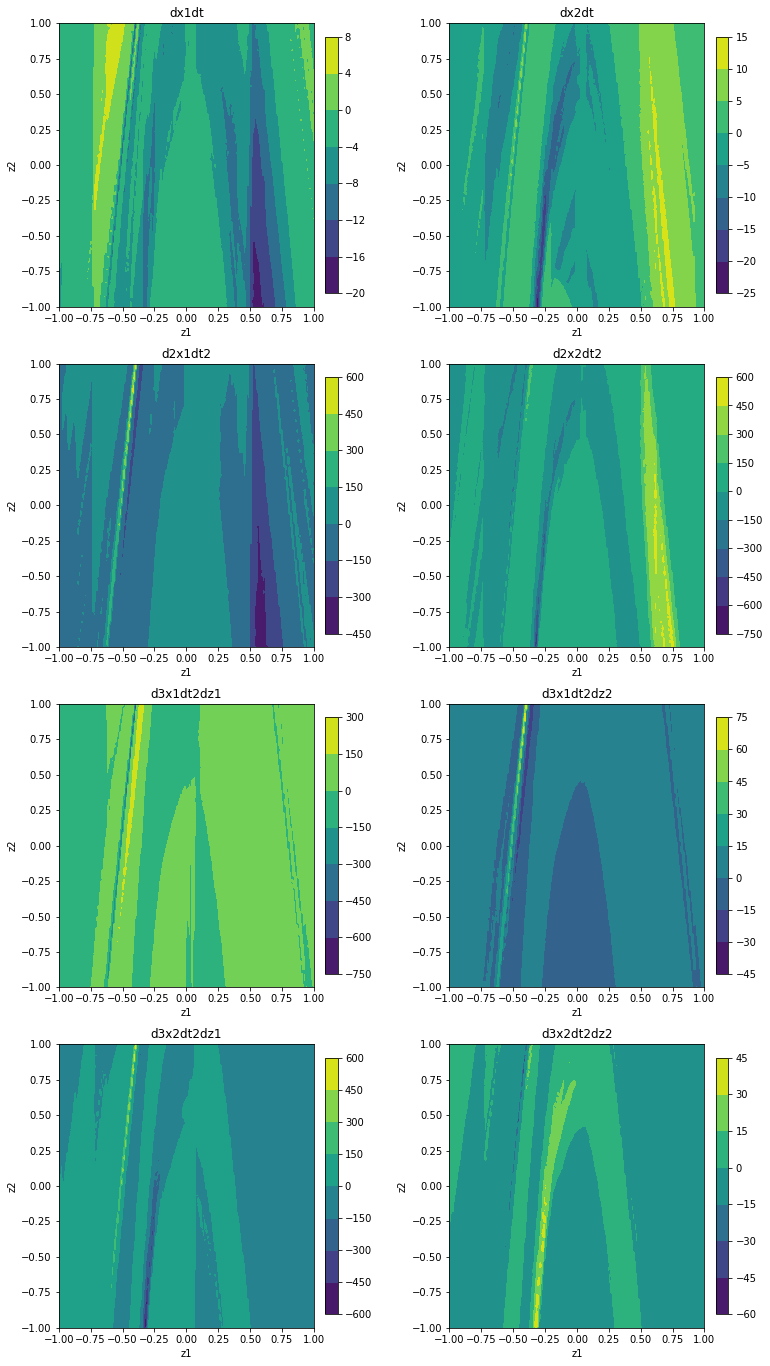

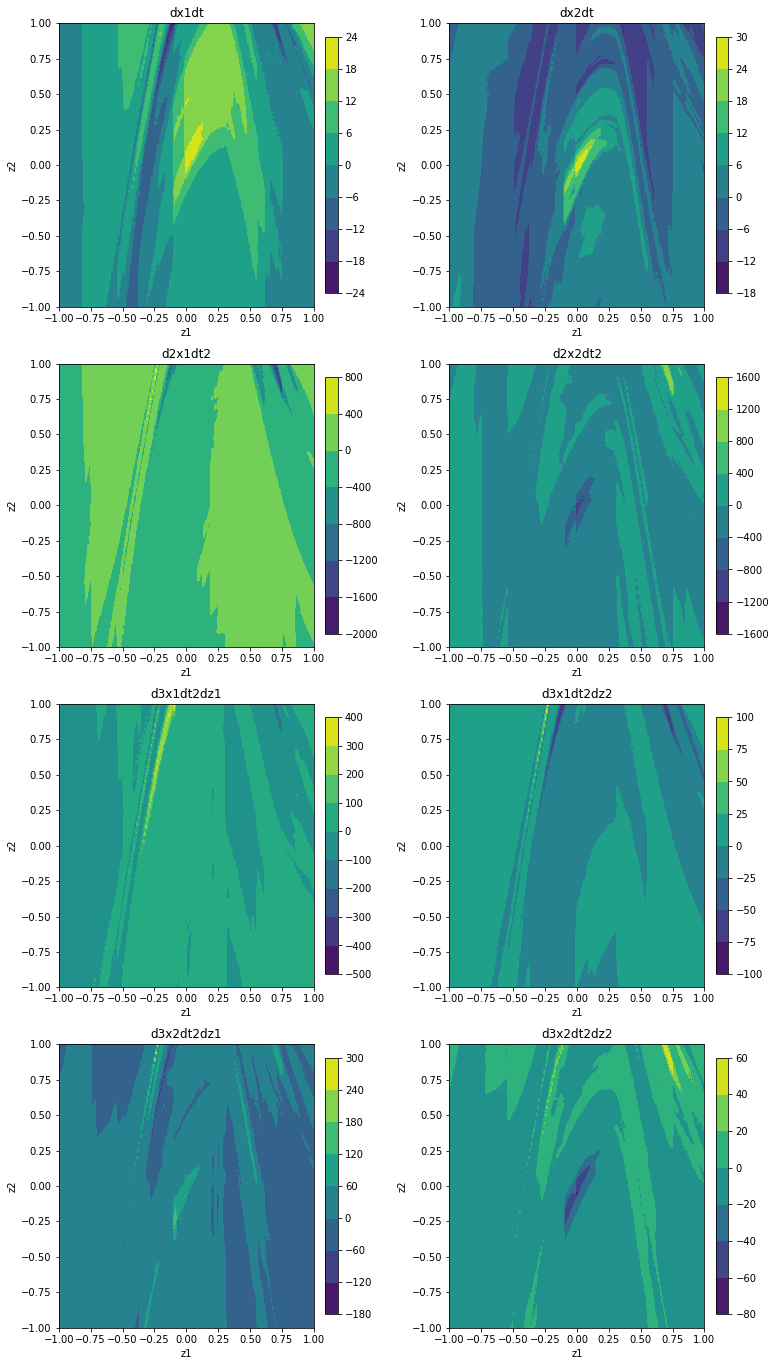

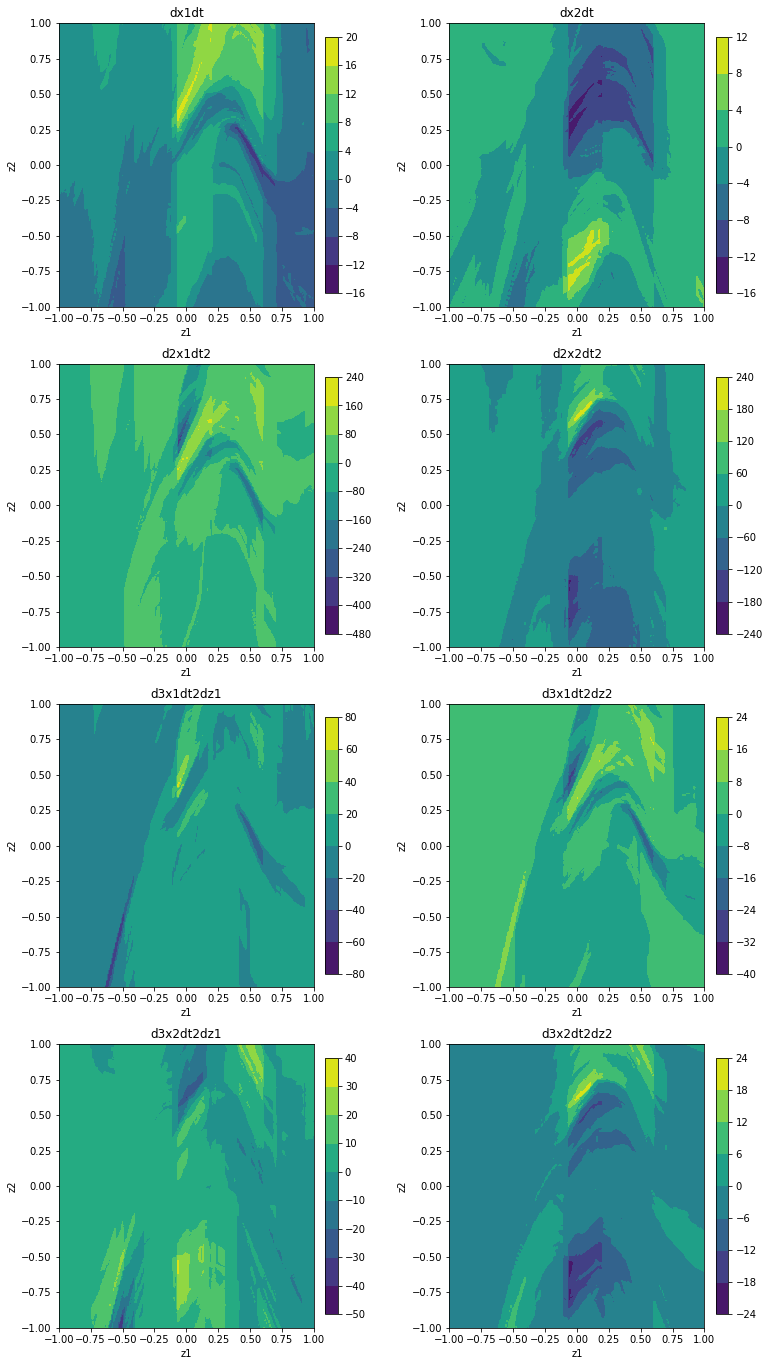

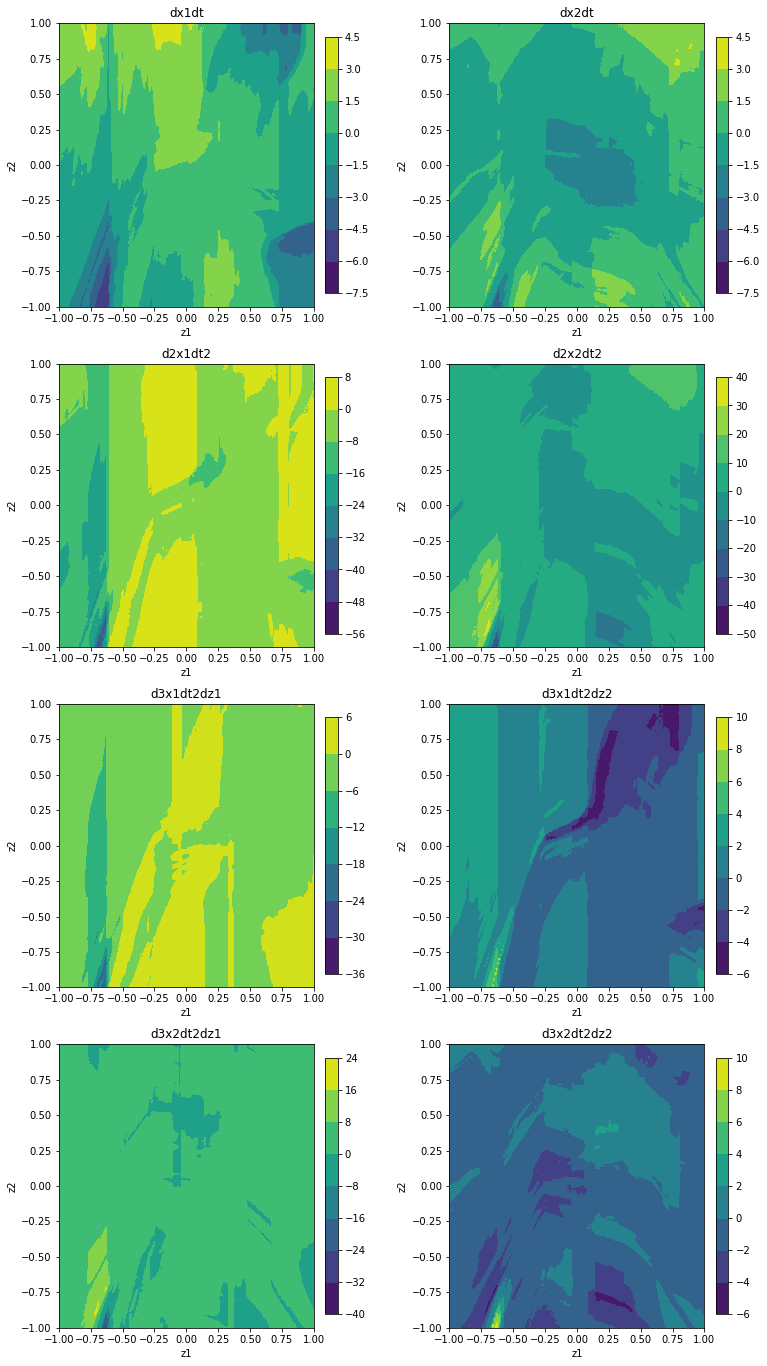

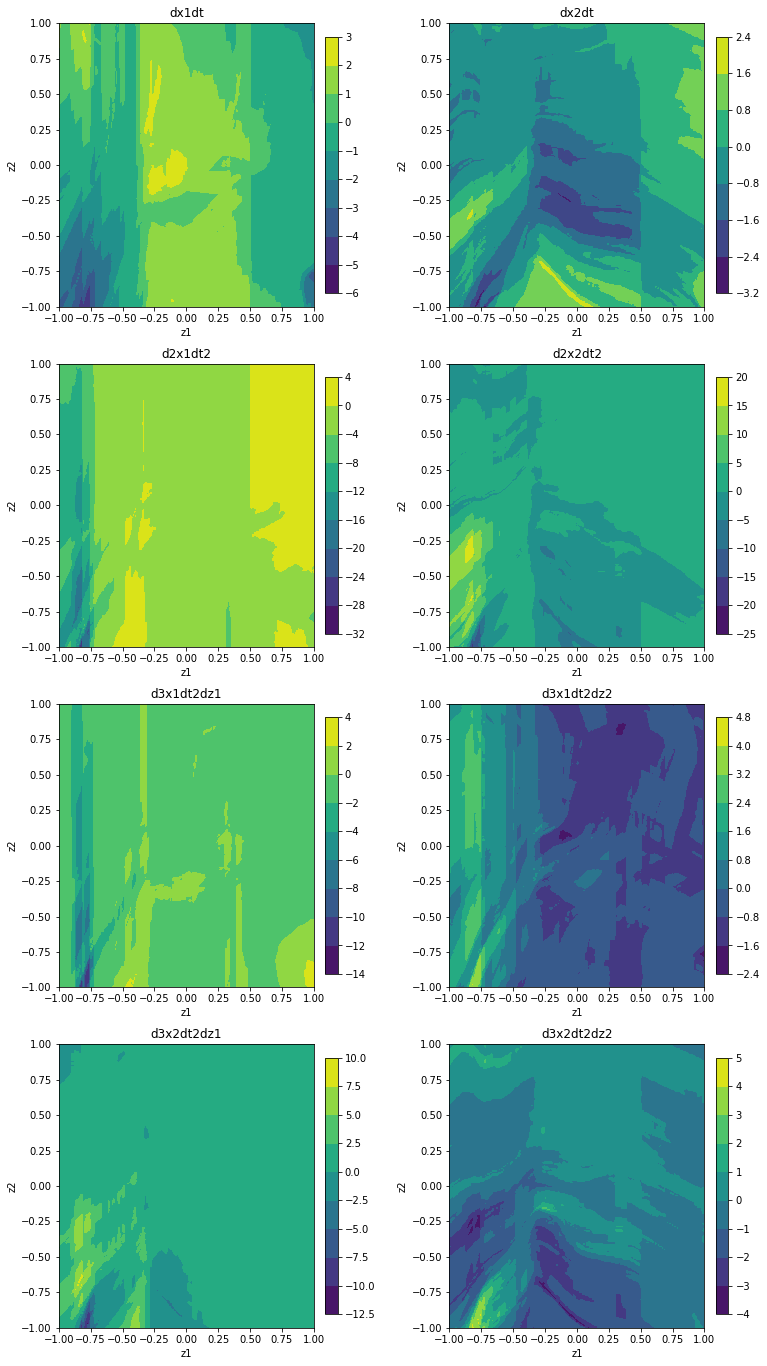

In [20]:
for time in np.arange(0.0,final_time,0.1):
    params[:,0] = time
    g1, g2, v = flow_model.extract_gradient(grid,params)

    # print(g1,g2,v)

    dx1dt = g1.numpy()[:,0,0].reshape(zx.shape[0],zy.shape[0])
    dx2dt = g1.numpy()[:,1,0].reshape(zx.shape[0],zy.shape[0])
    d2x1dt2 = g2.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d2x2dt2 = g2.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])

    d3x1dt2dz1 = v.numpy()[:,0,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x1dt2dz2 = v.numpy()[:,0,0,1].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz1 = v.numpy()[:,1,0,0].reshape(zx.shape[0],zy.shape[0])
    d3x2dt2dz2 = v.numpy()[:,1,0,1].reshape(zx.shape[0],zy.shape[0])

    fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(12,24))


    cs1 = ax[0,0].contourf(zxv,zyv,dx1dt)#,levels=levels)
    ax[0,0].set_title('dx1dt')
    cs2 = ax[0,1].contourf(zxv,zyv,dx2dt)#,levels=levels)
    ax[0,1].set_title('dx2dt')
    cs3 = ax[1,0].contourf(zxv,zyv,d2x1dt2)#,levels=levels)
    ax[1,0].set_title('d2x1dt2')
    cs4 = ax[1,1].contourf(zxv,zyv,d2x2dt2)#,levels=levels)
    ax[1,1].set_title('d2x2dt2')

    cs5 = ax[2,0].contourf(zxv,zyv,d3x1dt2dz1)#,levels=levels)
    ax[2,0].set_title('d3x1dt2dz1')

    cs6 = ax[2,1].contourf(zxv,zyv,d3x1dt2dz2)#,levels=levels)
    ax[2,1].set_title('d3x1dt2dz2')

    cs7 = ax[3,0].contourf(zxv,zyv,d3x2dt2dz1)#,levels=levels)
    ax[3,0].set_title('d3x2dt2dz1')

    cs8 = ax[3,1].contourf(zxv,zyv,d3x2dt2dz2)#,levels=levels)
    ax[3,1].set_title('d3x2dt2dz2')


    for i in range(4):
        for j in range(2):
            ax[i,j].set_xlabel('z1')
            ax[i,j].set_ylabel('z2')

    fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs3,ax=ax[1,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs4,ax=ax[1,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs5,ax=ax[2,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs6,ax=ax[2,1],fraction=0.046, pad=0.04)
    fig.colorbar(cs7,ax=ax[3,0],fraction=0.046, pad=0.04)
    fig.colorbar(cs8,ax=ax[3,1],fraction=0.046, pad=0.04)
    plt.subplots_adjust(wspace = 0.4)
    plt.show()